In [1]:

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
import random as rd
import cv2
import gc
import random


!pip install wfdb
import wfdb

In [2]:
!git clone https://github.com/AlexandrePerdereau/pfeECG.git

fatal: destination path 'pfeECG' already exists and is not an empty directory.


In [0]:
directory = 'pfeECG/mit-bih-arrhythmia-database-1.0.0/'
file = open(directory + 'RECORDS')
records = file.readlines()
file.close()

In [4]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [0]:
tailleMax = 0

In [0]:
def segmentation(typeBeat):

    liste1,liste2 = [],[]

    for e in records:
        signals, fields = wfdb.rdsamp(directory + e[0:-1]) 

        ann = wfdb.rdann(directory + e[0:-1], 'atr')
       
        ids = np.in1d(ann.symbol, typeBeat)
        imp_beats = ann.sample[ids]
        beats = (ann.sample)
        for i in imp_beats:
            beats = list(beats)
            j = beats.index(i)
            if(j!=0 and j!=(len(beats)-1)):
                x = beats[j-1]
                y = beats[j+1]
                diff1 = abs(x - beats[j])//2
                diff2 = abs(y - beats[j])//2
                signal0 = signals[beats[j] - diff1: beats[j] + diff2, 0]
                signal1 = signals[beats[j] - diff1: beats[j] + diff2, 1]
                
                #indMax = signal0.index(np.max(np.abs(signal0)))
                #indMax = np.where(np.abs(signal0) == np.max(np.abs(signal0)))
                #indMid = int(len(signal0)//2)
                #shift = indMax[0] - indMid
                
                #signal0 = np.roll(signal0, -shift)
                #signal1 = np.roll(signal1, -shift)
                
                #print(shift)
                #if shift > 0:
                 #   signal0 = np.roll(signal0, -shift)
                #elif shift < 0:
                 #   signal0 = np.roll(signal0, -shift)
                
                liste1.append(signal0)
                liste2.append(signal1)

    #liste1 = liste1[1:] 
    #liste2 = liste2[1:]
    return liste1,liste2

In [0]:
def padding(signal,lmax):
    signal0Padded = []
    signal1Padded = []
    for s0, s1 in list(zip(signal[0], signal[1])):
      length = len(s0)
      shift = (lmax - length)//2
      signal0Padded.append(np.pad(s0, (shift, shift), 'constant'))
      signal1Padded.append(np.pad(s1, (shift, shift), 'constant'))
    signalPadded = (signal0Padded,signal1Padded)
    return signalPadded

In [0]:
class ECGDataset(Dataset):

    def __init__(self, Dir):
        
        file = open(Dir+'RECORDS')
        records = file.readlines()
        file.close()
        
        good = ['N']
        leftBundleBlocks = ['L']
        rightBundleBlocks = ['R']
        atrialContraction = ['A']
        ventricularContraction = ['V']
        paced = ['/']
        ventricularEscape = ['E']
       # ventricularFlutterWave = ['!']
        
        NORMAL = segmentation(good)
        indexes = [i for i in range(len(NORMAL[0]))]
        #random.shuffle(NORMAL[0],NORMAL[1])
        #random.shuffle(NORMAL[1])
        #normal0 = NORMAL[0][0:10000]
        #normal1 = NORMAL[1][0:10000]
       # NORMAL = (normal0,normal1)
        
        random.shuffle(indexes)
        
        NORMALred = [tuple() for i in range(10000)]

        for i in range(10000):
          
          normal0 = NORMAL[0][indexes[i]]
          normal1 = NORMAL[1][indexes[i]]
          NORMALred[i] = (normal0,normal1)
       
        NORMALredt = np.transpose(NORMALred) 
        LBB = segmentation(leftBundleBlocks)
        RBB = segmentation(rightBundleBlocks)
        APC = segmentation(atrialContraction)
        PVC = segmentation(ventricularContraction)
        VEB = segmentation(ventricularEscape)
        PAB = segmentation(paced)

        
        
        tailleMax1 = len(max(NORMALredt[0], key = lambda i: len(i)))
        tailleMax2 = len(max(LBB[0], key = lambda i: len(i)))
        tailleMax3 = len(max(RBB[0], key = lambda i: len(i)))
        tailleMax4 = len(max(APC[0], key = lambda i: len(i)))
        tailleMax5 = len(max(PVC[0], key = lambda i: len(i)))
        tailleMax6 = len(max(VEB[0], key = lambda i: len(i)))
        tailleMax7 = len(max(PAB[0], key = lambda i: len(i)))

        global tailleMax
        tailleMax = np.max([tailleMax1,tailleMax2,tailleMax3,tailleMax4,tailleMax5,tailleMax6,tailleMax7])

        
        NORMALPAD = padding(NORMALredt,tailleMax)
        LBBPAD = padding(LBB,tailleMax)
        RBBPAD = padding(RBB,tailleMax)
        APCPAD = padding(APC,tailleMax)
        PVCPAD = padding(PVC,tailleMax)
        VEBPAD = padding(VEB,tailleMax)
        PABPAD = padding(PAB,tailleMax)

        
        #VFW = segmentation(ventricularFlutterWave)
        
 
        
        NORMALLabel = ['Normal']*len(NORMALPAD[0])
        LBBLabel = ['LBB']*len(LBBPAD[0])
        RBBLabel = ['RBB']*len(RBBPAD[0])
        APCLabel = ['APC']*len(APCPAD[0])
        PVCLabel = ['PVC']*len(PVCPAD[0])
        VEBLabel = ['VEB']*len(VEBPAD[0])
        PABLabel = ['PAB']*len(PABPAD[0])
       # VFWLabel = ['VFW']*len(VFW[0])

       
                
        
        
        self.Labels =np.array(NORMALLabel + LBBLabel + RBBLabel + APCLabel + PVCLabel + VEBLabel + PABLabel )
        self.Signals =  np.concatenate((NORMALPAD, LBBPAD, RBBPAD, APCPAD, PVCPAD, VEBPAD, PABPAD),axis = 1)

        
        
        
        
    def __len__(self):
        return len(self.Signals[0])

    def __getitem__(self, idx):

        sample = {'Signals': self.Signals[:,idx], 'Label': self.Labels[idx]}

        return sample
    
    
    

In [0]:
#debug de ECGDataset

tailleMax2 = len(max(LBB[0], key = lambda i: len(i)))
tailleMax2

LBBPAD = padding(LBB,tailleMax2)

plt.plot(LBBPAD[0][0])
plt.plot(LBBPAD[1][0])
plt.show()


In [0]:
DS = ECGDataset(Dir = directory)


In [0]:
def egalisationTailles(DS):
  for sample in DS:

    if len(sample['Signals'][0]) > tailleMax-1:
      sample['Signals'][0] = np.delete(sample['Signals'][0], tailleMax-1)
      sample['Signals'][1] = np.delete(sample['Signals'][1], tailleMax-1)

    
egalisationTailles(DS)    

In [0]:
#debug d'egalisationTailles

tailles = []

for sample in DS:
    
  
    tailles.append(len(sample['Signals'][0]))
        
tailleMax = np.max(tailles)
indexMax = np.argmax(tailles)

tailles

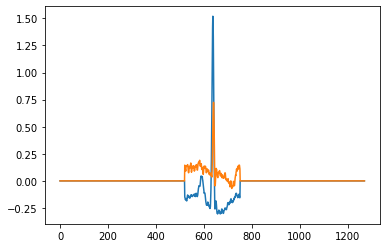

Normal


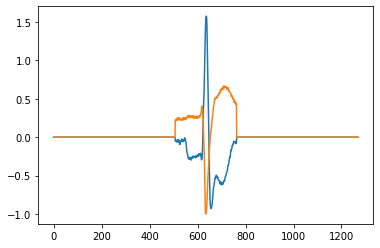

LBB


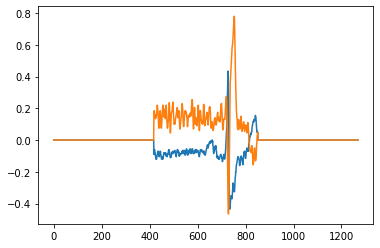

RBB


In [26]:
#test d'affichages 
#affichages de test
sample1 = DS[4]
sample2 = DS[12000]
sample3 = DS[25000]
sample = DS[0]
plt.plot(sample1['Signals'][0])
plt.plot(sample1['Signals'][1])
plt.show()
print(sample1['Label'])


plt.plot(sample2['Signals'][0])
plt.plot(sample2['Signals'][1])
plt.show()
print(sample2['Label'])

plt.plot(sample3['Signals'][0])
plt.plot(sample3['Signals'][1])
plt.show()
print(sample3['Label'])

In [0]:
#Ne pas utiliser
def normalize(DS):
    for sample in DS:
        sample['Signals'][0] = sample['Signals'][0][int(len(sample['Signals'][0]) /2)-100:int(len(sample['Signals'][0]) /2)+100]
        sample['Signals'][1] = sample['Signals'][1][int(len(sample['Signals'][1]) /2)-100:int(len(sample['Signals'][1]) /2)+100]
        #print(len(sample['Signals'][0]))
    return DS

#DS = normalize(DS)

In [0]:

sample = DS[40000]
plt.plot(sample['Signals'][0])
plt.plot(sample['Signals'][1])
sample['Label']

In [0]:
class subDataSet(Dataset):
    def __init__(self, sampleList):
        
        

        self.samples = sampleList

 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        sample = {'Signals': self.samples['Signals'][idx], 'Label': self.samples['Label'][idx]}

        return sample
    

In [0]:
def createSubDataSets(trainproportion,totalDataSet):
    train = []
    test = []
    for sample in DS:
        rand = rd.random()
        if (rand < trainproportion):
            train.append(sample)
        else:
            test.append(sample)
    trainSet = subDataSet(train)
    testSet = subDataSet(test)
    return trainSet, testSet

    

In [0]:
trainSet, testSet = createSubDataSets(0.70, DS)

In [0]:
len(trainSet), len(testSet) , len(DS)
#plt.plot(sample['Signals'][0])
#plt.plot(sample['Signals'][1])
#sample['Label']

In [0]:
# Transformation en image


def signals2Images(DS,label):
    
   
    count = 0

    for sample in DS:
      if sample['Label'] == label:
        fig = plt.figure(frameon=False) 
        plt.plot(sample['Signals'][0])
        plt.plot(sample['Signals'][1])
        plt.xticks([]), plt.yticks([])
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        
                 
        filename = 'pfeECG/images' + '/' + label + '/' + str(count)+'.png'
        fig.savefig(filename)
        im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        im_gray = cv2.resize(im_gray, (128, 128), interpolation = cv2.INTER_LANCZOS4)
        cv2.imwrite(filename, im_gray)
        count = count + 1
        print(count)
        plt.close()
        
        



In [0]:
gc.collect()

In [0]:
path = "pfeECG/images/" + 'LBB'
os.makedirs(path)
signals2Images(DS,'LBB')
gc.collect()

In [0]:
path = "pfeECG/images/" + 'RBB'
os.makedirs(path)
signals2Images(DS,'RBB')
gc.collect()

In [0]:
path = "pfeECG/images/" + 'APC'
os.makedirs(path)
signals2Images(DS,'APC')
gc.collect()

In [0]:
path = "pfeECG/images/" + 'PVC'
os.makedirs(path)
signals2Images(DS,'PVC')
gc.collect()

In [0]:
path = "pfeECG/images/" + 'VEB'
os.makedirs(path)
signals2Images(DS,'VEB')
gc.collect()

In [0]:
path = "pfeECG/images/" + 'PAB'
os.makedirs(path)
signals2Images(DS,'PAB')
gc.collect()

In [0]:
path = "pfeECG/images/" + 'Normal'
os.makedirs(path)
signals2Images(DS,'Normal')
gc.collect()

In [0]:
!zip -r /content/pfeECG/normalDatabase.zip /content/pfeECG/images/Normal

In [0]:
from google.colab import files
files.download("/content/pfeECG/normalDatabase.zip")